In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import sys
import os

In [85]:
import numpy as np 
import glob
import matplotlib.pyplot as plt
import sqlite3 as sq3
from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
import copy

In [86]:
print (os.getcwd())

/Users/msiebert/Documents/UCSC/Research/UCSC_spec_database


In [63]:
base_keck = '/Users/msiebert/Documents/UCSC/Research/Observing/Keck/'
host = '2019cpe'
night_path = '02152020_test/data/pre_reduced/{}_host/{}_host_ex/'.format(host,host)
spec_files_keck = glob.glob(base_keck+night_path+host+"*.fits")

base_lick = '/Users/msiebert/Documents/UCSC/Research/Observing/Lick_KAST/'
night_path = '08312019/data-2019-08-31-shane-Ryan.Foley/pre_reduced/final_reductions/'
spec_files_lick = glob.glob(base_lick+night_path+"*.fits")

In [64]:
def process_keck_file(spec):
    meta_dict = {}
    spec_fits=fits.open(spec)
    
    filename = spec.split('/')[-1]
    head=spec_fits[0].header
    meta_dict['FILENAME']  = filename
    meta_dict['OBJECT']  = head['OBJECT']
    
    flux, err = np.transpose(spec_fits[0].data)
    snr = np.round(np.median(flux/err),3)
    meta_dict['SNR'] = snr
    
    wavezero=float(head['CRVAL1'])
    wavedelt=float(head['CDELT1'])
    wave=np.arange(len(flux))*wavedelt+wavezero
    airmass=float(head['AIRMASS'])
    
    meta_dict['EXPTIME']  = float(head['EXPTIME'])
    meta_dict['AIRMASS'] = np.round(float(head['AIRMASS']),3)
    meta_dict['MINWAVE'] = np.round(float(head['W_RANGE'].split()[0]),4)
    meta_dict['MAXWAVE'] = np.round(float(head['W_RANGE'].split()[1]),4)
    meta_dict['WAVEDELT'] = np.round(wavedelt,4)
    meta_dict['CRVAL'] = np.round(wavezero,4)
    meta_dict['MJD'] = float(head['MJD-OBS'])
    meta_dict['UTC']  = head['UTC']
    meta_dict['POS_ANG'] = np.round(float(head['ROTPOSN'])+90, 2)
    meta_dict['FLUX_OBJ'] = head['FLUX_OBJ']
    
    radec = SkyCoord(head['RA'], head['DEC'], frame='icrs', unit=(u.hourangle, u.deg))
    meta_dict['RA_OBS'] = np.round(radec.ra.deg, 4)
    meta_dict['DEC_OBS'] = np.round(radec.dec.deg, 4)
#     apo = Observer.at_site("Keck")
#     date = head['DATE_BEG']
#     par_ang = apo.parallactic_angle(date.split('T')[0] + ' ' + date.split('T')[1], radec)
#     print (par_ang)
    
    meta_dict['OBSERVER'] = head['OBSERVER'].strip()
    meta_dict['REDUCER'] = head['REDUCER']
    
    meta_dict['INSTRUMENT'] = head['INSTRUME'].strip()
    meta_dict['GRATING'] = head['GRANAME'].strip()
    meta_dict['GRISM'] = head['GRISNAME'].strip()
    meta_dict['DICHROIC'] = head['DICHNAME'].strip()
    meta_dict['SLIT'] = head['SLITNAME'].strip()
    meta_dict['TELESCOPE'] = head['TELESCOP'].strip()
    
    if 'combined' in filename:
        meta_dict['COMBINED'] = 1
    else:
        meta_dict['COMBINED'] = 0
        
    if 'BAD' in filename:
        meta_dict['AP_GREATER_SEEING'] = 0
    else:
        meta_dict['AP_GREATER_SEEING'] = 1
        
    if 'arcsec' in filename:
        meta_dict['AP_SIZE'] = float(filename.split('arcsec')[0].split('_')[-2])
        meta_dict['AP_UNIT'] = 'arcsec'
        if 'SN' in filename.split('arcsec')[1]:
            meta_dict['AP_LOC'] = 'SN'
        else:
            meta_dict['AP_LOC'] = 'NUC'
        meta_dict['IS_KRON_RAD'] = 0
    elif 'kpc' in filename:
        meta_dict['AP_SIZE'] = float(filename.split('kpc')[0].split('_')[-2])
        meta_dict['AP_UNIT'] = 'kpc'
        if 'SN' in filename.split('kpc')[1]:
            meta_dict['AP_LOC'] = 'SN'
        else:
            meta_dict['AP_LOC'] = 'NUC'
        meta_dict['IS_KRON_RAD'] = 0
    elif 'rkron' in filename:
        meta_dict['AP_SIZE'] = float(filename.split('rkron')[0].split('_')[-2])
        meta_dict['AP_UNIT'] = 'arcsec'
        meta_dict['AP_LOC'] = 'NUC'
        meta_dict['IS_KRON_RAD'] = 1
    else:
        meta_dict['AP_SIZE'] = None
        meta_dict['AP_UNIT'] = None
        meta_dict['AP_LOC'] = None
        meta_dict['IS_KRON_RAD'] = 0
        
    return wave, flux, err, meta_dict
    
def process_lick_file(spec):
    meta_dict = {}
    spec_fits=fits.open(spec)
    
    filename = spec.split('/')[-1]
    head=spec_fits[0].header
    meta_dict['FILENAME']  = filename
    meta_dict['OBJECT']  = head['OBJECT']
    
    flux, err = np.transpose(spec_fits[0].data)
    snr = np.round(np.median(flux/err),3)
    meta_dict['SNR'] = snr
    
    wavezero=float(head['CRVAL1'])
    wavedelt=float(head['CDELT1'])
    wave=np.arange(len(flux))*wavedelt+wavezero
    airmass=float(head['AIRMASS'])
    
    meta_dict['EXPTIME']  = float(head['EXPTIME'])
    meta_dict['AIRMASS'] = np.round(float(head['AIRMASS']),3)
    meta_dict['MINWAVE'] = np.round(float(head['W_RANGE'].split()[0]),4)
    meta_dict['MAXWAVE'] = np.round(float(head['W_RANGE'].split()[1]),4)
    meta_dict['WAVEDELT'] = np.round(wavedelt,4)
    meta_dict['CRVAL'] = np.round(wavezero,4)
    ut_date = head['DATE-OBS'].strip()
    t = Time(ut_date, format='isot')
    meta_dict['MJD'] = float(t.mjd)
    meta_dict['UTC']  = ut_date.split('T')[1]
    meta_dict['POS_ANG'] = np.round(float(head['TUB']), 2) #TODO:check that tub is correct
    meta_dict['FLUX_OBJ'] = head['FLUX_OBJ']
    
    radec = SkyCoord(head['RA'], head['DEC'], frame='icrs', unit=(u.hourangle, u.deg))
    meta_dict['RA'] = np.round(radec.ra.deg, 4)
    meta_dict['DEC'] = np.round(radec.dec.deg, 4)
#     apo = Observer.at_site("Keck")
#     date = head['DATE_BEG']
#     par_ang = apo.parallactic_angle(date.split('T')[0] + ' ' + date.split('T')[1], radec)
#     print (par_ang)
    
    meta_dict['OBSERVER'] = head['OBSERVER'].strip()
    meta_dict['REDUCER'] = head['REDUCER']
    
    meta_dict['INSTRUMENT'] = head['VERSION'].strip()
    meta_dict['GRATING'] = head['GRATNG_N'].strip()
    meta_dict['GRISM'] = head['GRISM_N'].strip()
    meta_dict['DICHROIC'] = head['BSPLIT_N'].strip()
    meta_dict['SLIT'] = head['SLIT_N'].strip()
    meta_dict['TELESCOPE'] = head['OBSERVAT'].strip()
    
    if 'combined' in filename:
        meta_dict['COMBINED'] = 1
    else:
        meta_dict['COMBINED'] = 0
        
    if 'BAD' in filename:
        meta_dict['AP_GREATER_SEEING'] = 0
    else:
        meta_dict['AP_GREATER_SEEING'] = 1
        
    if 'arcsec' in filename:
        meta_dict['AP_SIZE'] = float(filename.split('arcsec')[0].split('_')[-2])
        meta_dict['AP_UNIT'] = 'arcsec'
        if 'SN' in filename.split('arcsec')[1]:
            meta_dict['AP_LOC'] = 'SN'
        else:
            meta_dict['AP_LOC'] = 'NUC'
        meta_dict['IS_KRON_RAD'] = 0
    elif 'kpc' in filename:
        meta_dict['AP_SIZE'] = float(filename.split('kpc')[0].split('_')[-2])
        meta_dict['AP_UNIT'] = 'kpc'
        if 'SN' in filename.split('kpc')[1]:
            meta_dict['AP_LOC'] = 'SN'
        else:
            meta_dict['AP_LOC'] = 'NUC'
        meta_dict['IS_KRON_RAD'] = 0
    elif 'rkron' in filename:
        meta_dict['AP_SIZE'] = float(filename.split('rkron')[0].split('_')[-2])
        meta_dict['AP_UNIT'] = 'arcsec'
        meta_dict['AP_LOC'] = 'NUC'
        meta_dict['IS_KRON_RAD'] = 1
    else:
        meta_dict['AP_SIZE'] = np.nan
        meta_dict['AP_UNIT'] = 'None'
        meta_dict['AP_LOC'] = 'None'
        meta_dict['IS_KRON_RAD'] = 0
        
    return wave, flux, err, meta_dict

def process_soar_file(head):
    return

In [65]:
spec_fits=fits.open(spec_files_keck[0])
head=spec_fits[0].header
print (head)

SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -64 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                    2 / Axis length                                    NAXIS2  =                 4066 / Axis length                                    EXTEND  =                    F / File may contain extensions                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        IRAF-TLM= '2020-05-12T22:04:42' / Time of last modification                     OBJECT  = '2019cpe_host'       / Name of the object observed                    COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H DATE    = '2020-05-12T22:04:43' / file creation date (YYYY-MM-DDThh:mm:ss UT)   COMMENT BEGIN observation-specific keywo

In [66]:
spec_fits=fits.open(spec_files_lick[0])
head=spec_fits[0].header
print (head)

SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -64 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                    2 / Axis length                                    NAXIS2  =                 2137 / Axis length                                    EXTEND  =                    F / File may contain extensions                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        DATE    = '2020-06-09T18:20:13' / Date FITS file was generated                  IRAF-TLM= '2020-06-09T18:20:13' / Time of last modification                     OBJECT  = '2019oat '           / Name of the object observed                    CRVAL1U =                  409 / COLUMN ORIGIN                                  CRVAL2U =                 3400 / ROW ORIGIN                                     CDELT1U =                    1 / COLUMN 

FILENAME 2019cpe_host-blue-20200216_ap5_2.0_kpc.fits
OBJECT 2019cpe_host
SNR 26.031
EXPTIME 900.0
AIRMASS 1.278
MINWAVE 3140.0
MAXWAVE 5640.0
WAVEDELT 0.6149
CRVAL 3140.1381
MJD 58895.379723
UTC 09:06:48.03
POS_ANG 23.0
FLUX_OBJ Feige34
RA_OBS 147.5542
DEC_OBS -14.0277
OBSERVER siebert, dimitriadis, foley
REDUCER msiebert
INSTRUMENT LRISBLUE
GRATING 400/8500
GRISM 600/4000
DICHROIC 560
SLIT long_1.0
TELESCOPE Keck I
COMBINED 0
AP_GREATER_SEEING 1
AP_SIZE 2.0
AP_UNIT kpc
AP_LOC NUC
IS_KRON_RAD 0


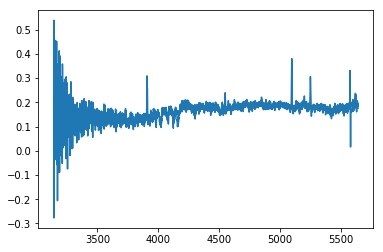

In [67]:
wave, flux, err, meta_dict = process_keck_file(spec_files_keck[0])
for m in meta_dict.keys():
    print (m, meta_dict[m])
plt.plot(wave,flux)
plt.show()

FILENAME 2019oat-red-20190901_ap1.fits
OBJECT 2019oat
SNR 3.544
EXPTIME 600.0
AIRMASS 2.299
MINWAVE 5400.0
MAXWAVE 10800.0
WAVEDELT 2.5269
CRVAL 5400.3655
MJD 58727.48741585648
UTC 11:41:52.73
POS_ANG 197.2
FLUX_OBJ BD262606
RA 13.5086
DEC -23.4789
OBSERVER Chisholm
REDUCER msiebert
INSTRUMENT kastr
GRATING 300/7500
GRISM 452/3306
DICHROIC d57
SLIT 2.0 arcsec
TELESCOPE lick
COMBINED 0
AP_GREATER_SEEING 1
AP_SIZE nan
AP_UNIT None
AP_LOC None
IS_KRON_RAD 0


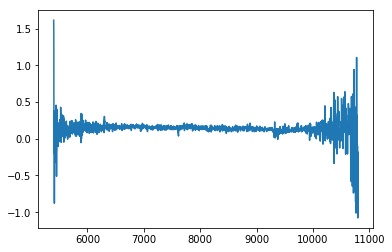

In [68]:
wave, flux, err, meta_dict = process_lick_file(spec_files_lick[0])
for m in meta_dict.keys():
    print (m, meta_dict[m])
plt.plot(wave,flux)
plt.show()

In [69]:
def setup_db(spec, new_db_name, telescope):
    
    print ('Wiping database and creating new table...')
    con = sq3.connect(new_db_name)
    cur = con.cursor()
    con.execute("""DROP TABLE IF EXISTS SPECTRA""")

    db_setup_fits = spec
    if telescope == 'keck':
        wave, flux, err, meta_dict = process_keck_file(spec)
    elif telescope == 'lick':
        wave, flux, err, meta_dict = process_lick_file(spec)
    else:
        print ('Only lick and keck implemented so far')
        return 
    print (meta_dict['FILENAME'])
    db_setup_str = """CREATE TABLE IF NOT EXISTS SPECTRA (FILENAME TEXT PRIMARY KEY, """
    type_dict = {'str': 'TEXT', 'float64': 'REAL', 'float': 'REAL', 'int': 'BIT'}
    for m in meta_dict:
        if m != 'FILENAME' and type(meta_dict[m]) != None:
            print (m)
            db_setup_str = db_setup_str + m + ' ' + type_dict[type(meta_dict[m]).__name__] + ', '
    db_setup_str = db_setup_str + 'RAW_FLUX BLOB, '
    db_setup_str = db_setup_str + 'RAW_ERR BLOB'
    db_setup_str = db_setup_str + ')'
    
    con.execute(db_setup_str)
    return db_setup_str

def add_spectrum_to_db(new_db_name, spec, telescope):
    con = sq3.connect(new_db_name)
    if telescope == 'keck':
        wave, flux, err, meta_dict = process_keck_file(spec)
    elif telescope == 'lick':
        wave, flux, err, meta_dict = process_lick_file(spec)
    else:
        print ('Only lick and keck implemented so far')
        return 
    flux_binary = flux.tobytes()
    err_binary = err.tobytes()
    print ('Adding:', meta_dict['FILENAME'])
    
    add_str = """INSERT INTO SPECTRA( """
    meta_data = ()
    for m in meta_dict:
        add_str = add_str + m + ', '
        meta_data = meta_data + (meta_dict[m],)
        
    add_str = add_str + 'RAW_FLUX, '
    meta_data = meta_data + (flux_binary,)
    add_str = add_str + 'RAW_ERR)'
    meta_data = meta_data + (err_binary,)
    add_str = add_str + ' VALUES('
    for i in range(len(meta_dict)+2):
        add_str = add_str + '?, '
    add_str = add_str[0:-2] + ')'
    con.execute(add_str, meta_data)
    con.commit()

In [70]:
new_db_name = '../UCSC_SPEC_DATA_DEV.db'
print (spec_files_lick[0])
db_setup_str = setup_db(spec_files_lick[0], new_db_name, 'lick')
# db_setup_str = setup_db(spec_files_lick[0], new_db_name, 'keck')
print (db_setup_str)

/Users/msiebert/Documents/UCSC/Research/Observing/Lick_KAST/08312019/data-2019-08-31-shane-Ryan.Foley/pre_reduced/final_reductions/2019oat-red-20190901_ap1.fits
Wiping database and creating new table...
2019oat-red-20190901_ap1.fits
OBJECT
SNR
EXPTIME
AIRMASS
MINWAVE
MAXWAVE
WAVEDELT
CRVAL
MJD
UTC
POS_ANG
FLUX_OBJ
RA
DEC
OBSERVER
REDUCER
INSTRUMENT
GRATING
GRISM
DICHROIC
SLIT
TELESCOPE
COMBINED
AP_GREATER_SEEING
AP_SIZE
AP_UNIT
AP_LOC
IS_KRON_RAD
CREATE TABLE IF NOT EXISTS SPECTRA (FILENAME TEXT PRIMARY KEY, OBJECT TEXT, SNR REAL, EXPTIME REAL, AIRMASS REAL, MINWAVE REAL, MAXWAVE REAL, WAVEDELT REAL, CRVAL REAL, MJD REAL, UTC TEXT, POS_ANG REAL, FLUX_OBJ TEXT, RA REAL, DEC REAL, OBSERVER TEXT, REDUCER TEXT, INSTRUMENT TEXT, GRATING TEXT, GRISM TEXT, DICHROIC TEXT, SLIT TEXT, TELESCOPE TEXT, COMBINED BIT, AP_GREATER_SEEING BIT, AP_SIZE REAL, AP_UNIT TEXT, AP_LOC TEXT, IS_KRON_RAD BIT, RAW_FLUX BLOB, RAW_ERR BLOB)


In [71]:
# for spec in spec_files_keck:
#     add_spectrum_to_db(spec)
for spec in spec_files_lick:
    add_spectrum_to_db(new_db_name, spec, 'lick')

Adding: 2019oat-red-20190901_ap1.fits
Adding: 2019oat-combined-20190901_ap1.fits
Adding: 2019oat-blue-20190901_ap1.fits


In [72]:
class spectrum(object):
    """A generic class to represent a spectrum and its associated metadata
    """
    def __init__(self, wavelength = None, flux = None, err = None, meta_dict=None):
        self.wavelength = wavelength
        self.flux = flux
        self.err = err
        self.meta_dict = meta_dict

In [73]:
def grab_all_spec_data(sql_input, db_file = None):

    if db_file is None:
        db_file = glob.glob('../*.db')[0]

    con = sq3.connect(db_file)
    print ("Collecting data from", db_file, "...")
    cur = con.cursor()

    spec_Array = []

    spec_table = cur.execute('PRAGMA TABLE_INFO({})'.format("SPECTRA"))
    spec_cols = [tup[1] for tup in cur.fetchall()]
    cur.execute(sql_input)
 
    spec_metadata = {}
    spec_list = []
    for row in cur:
        """retrieve spectral metadata.
        """
        for i, value in enumerate(row):
            if spec_cols[i] == 'RAW_FLUX':
                flux = np.frombuffer(value, dtype='>f8')
            elif spec_cols[i] == 'RAW_ERR':
                err = np.frombuffer(value, dtype='>f8')
            else:
                spec_metadata[spec_cols[i]] = value
        wave = np.arange(len(flux))*spec_metadata['WAVEDELT']+spec_metadata['MINWAVE']
        spec =  spectrum(wavelength=wave, flux=flux, err=err, meta_dict=spec_metadata)
        spec_list.append(copy.deepcopy(spec))
        
    for spec in spec_list:
        print(spec.meta_dict['FILENAME'])
    print (len(spec_list), 'Total Spectra found')
    return spec_list

In [81]:
query = "SELECT * from Spectra"
spec_list = grab_all_spec_data(query)

2019oat-red-20190901_ap1.fits
2019oat-combined-20190901_ap1.fits
2019oat-blue-20190901_ap1.fits
3 Total Spectra found


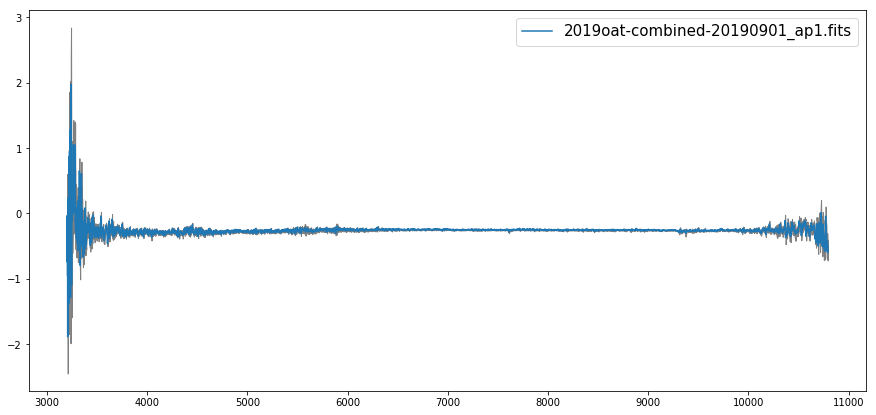

In [82]:
plt.figure(figsize=[15,7])
buff=0.3
for i, nspec in enumerate(np.asarray(spec_list)):
    if nspec.meta_dict['COMBINED']:
        plt.plot(nspec.wavelength, nspec.flux - i*buff, drawstyle='steps-mid', label=nspec.meta_dict['FILENAME'])
        plt.fill_between(nspec.wavelength, nspec.flux - i*buff - nspec.err, nspec.flux - i*buff + nspec.err, color = 'gray')
        plt.legend(fontsize=15, loc=1)
plt.show() 

[3 1 0 4 2]


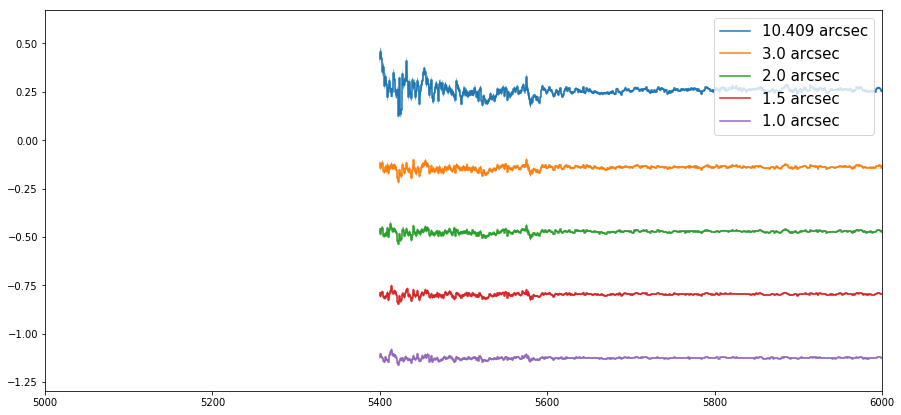

In [230]:
plt.figure(figsize=[15,7])
aps = []
new_list = []
for spec in spec_list:
    if spec.meta_dict['AP_UNIT'] == 'arcsec' and 'red' in spec.meta_dict['FILENAME'] and 'SN' not in spec.meta_dict['FILENAME']:
        aps.append(spec.meta_dict['AP_SIZE'])
        new_list.append(spec)
inds = np.flip(np.argsort(aps))
print (inds)

buff=0.3
for i, nspec in enumerate(np.asarray(new_list)[inds]):
    lab = str(nspec.meta_dict['AP_SIZE']) + ' '+ nspec.meta_dict['AP_UNIT']
    plt.plot(nspec.wavelength, nspec.flux - i*buff, drawstyle='steps-mid', label=lab)
    plt.fill_between(nspec.wavelength, nspec.flux - i*buff - nspec.err, nspec.flux - i*buff + nspec.err)
    plt.legend(fontsize=15, loc=1)
plt.xlim([5000,6000])
# plt.ylim([-.05,.8])
plt.show() 

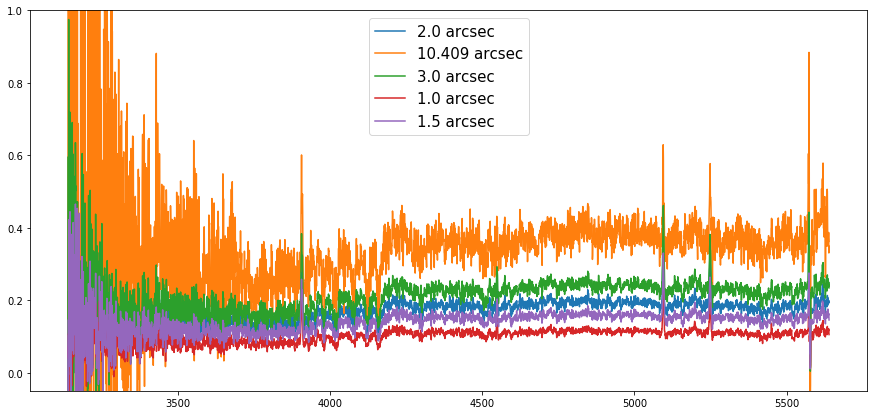

In [228]:
plt.figure(figsize=[15,7])
for spec in spec_list:
#     print (spec.meta_dict['FILENAME'])
    if spec.meta_dict['AP_UNIT'] == 'arcsec' and 'blue' in spec.meta_dict['FILENAME'] and 'SN' not in spec.meta_dict['FILENAME']:
        lab = str(spec.meta_dict['AP_SIZE']) + ' '+ spec.meta_dict['AP_UNIT']
        plt.plot(spec.wavelength, spec.flux, label=lab)
        plt.legend(fontsize=15)
# plt.xlim([3800,4000])
plt.ylim([-.05,1])
plt.show()